<a href="https://colab.research.google.com/github/iust-deep-learning/tensorflow-2-tutorial/blob/master/part_03_model_design_apis/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow 2.0 Tutorial: Part #3 Model Design APIs


TensorFlow 2.0 Tutorial by IUST
*   Last Update: April 2020
*   Official Page: https://github.com/iust-deep-learning/tensorflow-2-tutorial





---




Please run the following cell before going through the rest of the tutorial.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np

from pprint import pprint

---

Tensorflow 2 provides an extensive set of APIs for designing models: less-flexible yet easier-to-use APIs for machine learning engineers, and highly-configurable APIs for researchers. In this part, we will take a look at all these kinds of APIs and learn when to use them. Keras is Tensorflow's main high-level APIs. As you may know, Keras itself is a standalone framework that unifies Deep Learning model designs. However, Tensorflow has its own version of Keras called `tf.keras`. Before going any further, let's see how this customized compared to the original one:

- `tf.keras` is a re-implementation of the Keras API.
- `tf.keras` has much better integration with the rest of Tensorflow framework.
- Distributed training is much easier in `tf.keras`.
- `tf.keras` supports Eager execution (dynamic graph).
- There is no one-to-one relation. but, most of the useful stuffs are also present in Tensorflow.

So, let's explore the tf.keras package and see what it offers:
- Keras API (tf.keras.*)
  - **Engine**: model training and evaluation loop
    - **Base Layer, Base Model, Sequential**: primary model designing apis
  - **Layers**: various subclasses of Base Layer
  - **Losses, Metrics**
  - **Callbacks**
  - **Optimizers**
  - **Regularizes, Constraints**
- `tf.Module()`: Base neural network module class that only tracks `tf.Variable` recursively. 




## Sequential APIs

---



The sequential APIs are the easiest and most straightforward way of defining models. You can simply build your desired model by stacking a bunch of layers. Here is an example 3-layer MLP network:

In [0]:
import tensorflow as tf 
from tensorflow.keras import layers

# Using model.add(a layer instance)
model = tf.keras.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(784,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Passing a list of layer instances
model = tf.keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(784,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [0]:
# Fake input
bs = 5
inp = tf.random.normal(shape=[bs, 784])

# Run the model
out = model(inp)
out

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0.04505382, 0.20075786, 0.03123527, 0.11645294, 0.12240309,
        0.12936935, 0.05056305, 0.14792503, 0.08842111, 0.06781843],
       [0.07226963, 0.06196825, 0.05810726, 0.04026051, 0.35287297,
        0.05639529, 0.0403906 , 0.0858349 , 0.20538603, 0.02651452],
       [0.07688943, 0.11240806, 0.10281783, 0.13920331, 0.10525569,
        0.08886977, 0.06056084, 0.08903328, 0.12461153, 0.10035025],
       [0.13825044, 0.06067   , 0.07191754, 0.11396584, 0.14393723,
        0.08707619, 0.06842862, 0.11545058, 0.1453219 , 0.05498158],
       [0.16079724, 0.08599699, 0.04688931, 0.1488415 , 0.11901367,
        0.0673555 , 0.03342271, 0.11410583, 0.17314202, 0.05043523]],
      dtype=float32)>

Although it is correct that you can stack up layers using the sequential API, the sequential API is a way of defining a sequence of computation (similar to Computation Graph) in which every building block of this sequence is a layer. For example, you can create a seq2seq model by connecting two blocks: encoder and decoder. In this case, we are not stacking up layers in theory (since stacking decoder on top of the encoder is not meaningful); we are just connecting the output of the encoder to the input of the decoder i.e., creating a computation graph.

Here are the common parameters in defining layers:

In [0]:
# Change the activation function (optional)
layers.Dense(64, activation='sigmoid')

# A linear layer: h = W.x + b

# Set the kernel (W) initializer. Default value: glorot_uniform layers.Dense(64, kernel_initializer='orthogonal')
# Set the bias (b) initializer. Default value: zeros
layers.Dense(64, bias_initializer='random_uniform_initializer')

# Set the kernel regularizer
layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l1(0.01))
# Set the bias regularizer
layers.Dense(64, bias_regularizer=tf.keras.regularizers.l2(0.01))


## Also, you can use tf.keras.* names

# Change the activation function (optional)
layers.Dense(64, activation=tf.keras.activations.sigmoid) 

# A linear layer: h = W.x + b

# Set the kernel (W) initializer. Default value: glorot_uniform
layers.Dense(64,
      kernel_initializer=tf.keras.initializers.GlorotUniform())
# Set the bias (b) initializer. Default value: zeros
layers.Dense(64,
      bias_initializer=tf.keras.initializers.RandomUniform())

# Set the kernel regularizer
layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l1(0.01))
# Set the bias regularizer
layers.Dense(64, bias_regularizer=tf.keras.regularizers.l2(0.01))

### The Layer Concept


Before continuing to the next section, let's see what these layers actually (building block) are! Layers are primarily resposible for following tasks:

- Computation from a batch of inputs to a batch of outputs.
- Manages state (trainable weights, non-trainable weights).
- Tracks losses and metrics.
- Automated compatibility checks (static shape inference).
- Can be frozen (useful in fine-tuning and Transfer Learning).
- Can be serialized and deserialized (useful for storing the model).

We will discuss implementing a custom layer in next few sections.




## Functional APIs
---

<p align="center">
<img src="https://imgur.com/download/YUOgCeS" width="800" />
<br/>
<a href="https://arxiv.org/pdf/1602.07261.pdf">Szegedy et al.</a>
</p>

The functional API provides a more sophisticated way to define the computation graph such a DAG (Directed Acyclic Graph). Sequential API was limited so that you could only sequentially assemble the graph. For example, if you wanted to use the output of a layer in two others, you were limited. Functional API solves this. Here is the previous example using the functional API:

In [0]:
import tensorflow as tf 
from tensorflow.keras import layers


inputs = tf.keras.Input(shape=(784,))

x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

Get a summary of the model you've just created

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


Or maybe the actual DAG

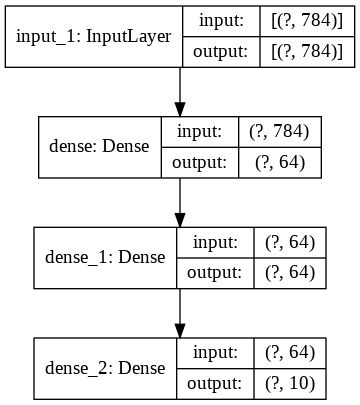

In [0]:
tf.keras.utils.plot_model(model, 'plot.png', show_shapes=True)

### Example: Visual Question Answering

In this section we will implement the simplest model to solve the VQA task. Here is the task:

**Input Image:**

<p align="center">
<img src="https://imgur.com/download/BLrsLU5" width="300" />
<br/>
Photo by Adrian Pereira on Unsplash
</p>

**Question:** What animal are these?

**Answer:** Koala



The model:
<p align="center">
<img src="https://imgur.com/download/KpSzWYe" width="300" />
</p>

In [0]:
import tensorflow as tf 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM, Dense

# image input
image_input = Input(shape=(128, 128, 3))

# Encode the image into an abstract
# representation
encoded_image = Conv2D(64, (3, 3), 
       activation='relu')(image_input)
encoded_image = MaxPooling2D()(encoded_image)
encoded_image = Flatten()(encoded_image)

# Vectorized input question
question_input = Input(shape=(None,),
                       dtype='int32')

# Encode the question into a single-
# vector representation
embedded = Embedding(
    input_dim=5000,
    output_dim=128,
    mask_zero=True)(question_input)

encoded_question = LSTM(128)(embedded)

# Concat the vector representations
merged = layers.concatenate([
    encoded_image, encoded_question])

# Use an MLP to produce the output
output = Dense(1000, 
    activation='softmax')(merged)

model = tf.keras.Model([image_input, question_input], output)
model.summary()

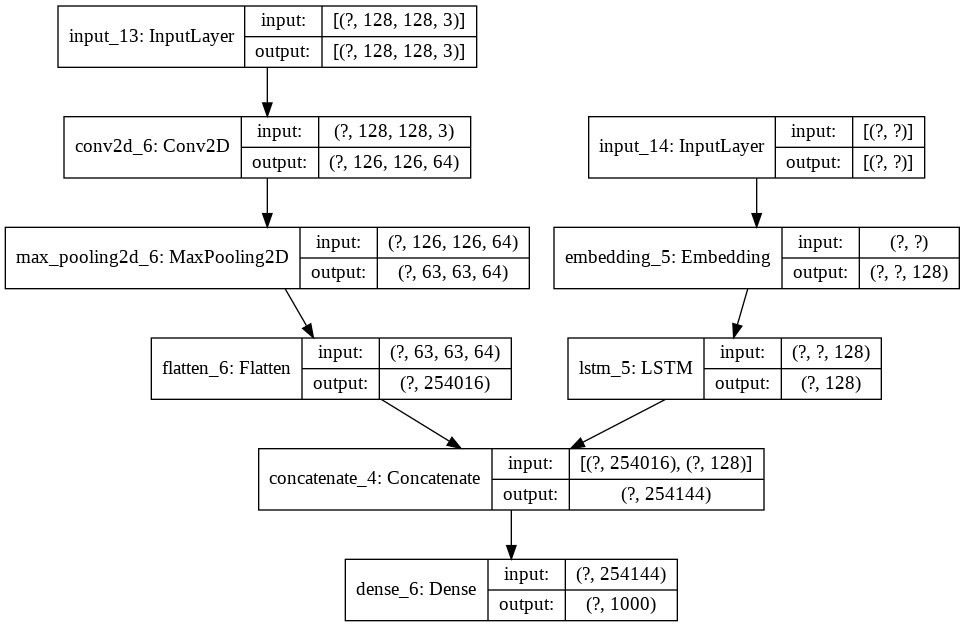

In [0]:
tf.keras.utils.plot_model(model, 'plot.png', show_shapes=True)

### Exercise #1: Product Review Classifier
Suppose that we have an online store (e.g., Amazon), and users can put a comment on products if they have bought them. Then, we want to find 1) whether the user would like to recommend the product 2) the sentiment of that review. Your model is given the title, the body, and the category of the review.
Here are the details of inputs and outputs:

Inputs
-  Title: Vectorized & padded input (can consist of multiple word)
-  Body: Vectorized & padded review content
-  Product Category: one category out of 12 (one-hot representation)

Output
-  Sentiment score: 3 possibilities (bad, medium, good)
-  Recommend: Wether the user recommends the product

Requirement
- You should only have 1 embedding matrix (i.e. share the embedding layer)


In [0]:
num_categories = 12

title_input = ... # Variable-length sequence of ints
body_input = ... # Variable-length sequence of ints
cat_input = ... # One-hot representation (dtype=tf.float32)

encoded_title = ... # 100-d representation
encoded_body = ... # 100-d representation

output_sentiment = ... # Model prediction of sentiment
output_recom = ... # Model prediction of the user's recommendation status

model = ... # Final Model

In [0]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

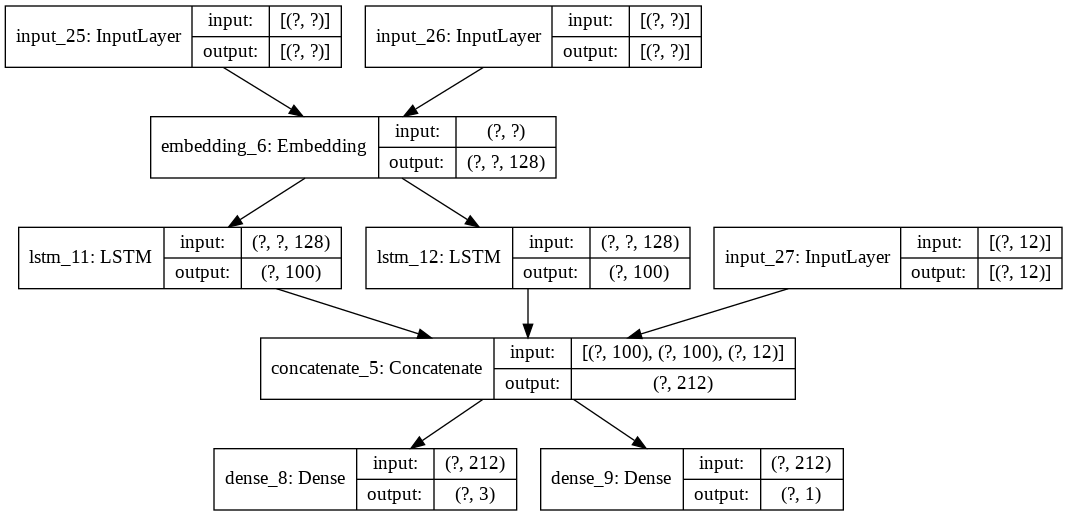

In [0]:
# Check yours against the following plot

## Writing Custom Layers
---
In many cases, the built-in set of layers cannot satisfy your particular needs. Therefore, you have to create your own layers. Creating our layer can be achieved by extending the `tf.keras.layers.Layer` class. In this section, we will discuss the topic in more details.

Here is the body of a custom layer:

In [0]:
class MyLayer(layers.Layer):
  def __init__(self, arg1,arg2, ...):
    super().__init__(...)
    ...
  
  def build(self, input_shape):
    ...

  def compute_output_shape(self, input_shape):
    ...

  def compute_mask(self, inputs, mask=None):
    ...

  def call(self, inputs):
    ...

  def get_config(self):
    ...


Let's create a very basic layer using the layer subclassing:


In [0]:
class Linear(layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        
        initializer = tf.initializers.GlorotUniform()
        self.w = tf.Variable(initializer([input_dim, units]),
                            name="kernel")

        initializer = tf.initializers.Zeros()
        self.b = tf.Variable(initializer([units]),
                            name="bias")
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

**The difference between our Linear class and Keras' Dense Layer**

First, look at how we use these two layers:

In [0]:
# Ours:
l1 = Linear(units=10, input_dim=2)

# Keras'
l2 = tf.keras.layers.Dense(units=10)

Can you spot the difference in their usage? The fact here is that in our implementation, we needed to get the input dimension from our class' users since we depend on that in creating our weight matrices. So, how does the Keras version do it this without getting the input dimension in its input? 

### Laziness!

The trick that Keras version leverages is laziness! That is, it infers the shape of the input (and thus its dimension) only after it receives the actual input. Then, it creates the weight matrices upon its invocation (not during the construction). So, let's see how our implementation can become lazy!

In [0]:
class Linear(layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                initializer='random_normal',
                                trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                initializer=‘zeros',
                                trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

x = tf.ones((2, 2))
linear_layer = Linear(4)
y = linear_layer(x)
print(y)

### Make it Serializable 


In order for Tensorflow to save and load the model from the disk, we need to make our custom layers serializable. To make the layer serializable, we only need to implement a single method in our class, and Tensorflow will do the rest for us. 

In [0]:
class Linear(layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                initializer='random_normal',
                                trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                initializer=‘zeros',
                                trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        config = super(Linear, self).get_config()
        config.update({'units': self.units})
        return config

The `get_config(self)` method should return a string-to-(any serializable values such as numbers or strings) dictionary. Basically, these values would be our layer's hyperparameters: number of neurons, the activation function, and so forth.

In [0]:
layer = Linear(64)
config = layer.get_config()
config

In [0]:
new_layer = Linear.from_config(config)

### Masking

Matrix computations require a fixed shape and constant dimension during the execution on GPUs and CPUs. However, since our computations are mostly based on batches,  we will definitely have data points where the dimensions can not be consistent across each batch, e.g., variable data such as text. To sidestep this issue, we pad the dataset samples with extra units so that each sample becomes as long as the longest sequence. But for the model and Keras to understand our padding, we have to inform them in some way. Masking is the way that Keras understands the padding. The mask matrix is a boolean matrix that its elements are only one when the data is valid.

When it comes to masking, Keras layers behave in 3 ways:
1. Mask Consumers
2. Mask Propagators
3. Mask Generators

Here are the general structure for those types:

In [0]:
class ConsumerLayer(layers.Layer):
    def call(self, inputs, mask=None):
        ...


class MaskPassThroughLayer(layers.Layer):
    def __init__(self, ...):
        self.supports_masking = True


class GeneratorLayer(layers.Layer):
    def __init__(self, ...):
        self.supports_masking = True

    def compute_mask(self, inputs, mask=None):
        ...

#### An Example


In [0]:
class CustomEmbedding(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, mask_zero=False):
        super(CustomEmbedding, self).__init__()
        self.supports_masking = True
        self.mask_zero = mask_zero
    
    def build(self, input_shape):
        ...
    def call(self, inputs):
        ...

    def compute_mask(self, inputs, mask=None):
        if not self.mask_zero:
            return None
        return tf.not_equal(inputs, 0)

In [0]:
layer = CustomEmbedding(10, 32, mask_zero=True)
x = np.array(
    [[2, 3, 4, 0, 0], 
     [3, 3, 4, 9, 20], 
     [9, 11, 1, 0, 0]], dtype=np.int32)

y = layer(x)
mask = layer.compute_mask(x)

# mask is: 
# tf.Tensor(
# [[ True  True  True False False]
#  [ True  True  True  True  True]
#  [ True  True  True False False]], shape=(3, 5), dtype=bool)

### Exercise #2: Max-pooling through time
One of the technique that originates from Computer Vision is called Max pooling. As you might remember, this technique reduces the impact of spatial information in the image. For example, If your CNN says, "Yay! I found a wheel at the position (x,y).", your Max-pooling will convert this sentence to "Yay! I found a wheel in this image."  Intuitively We can use the max-pooling procedure in any configuration beside an image. Here is an example of Max-pooling application in recurrent networks:

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg05_assets/05_rnn_max_pooling.png" width="450" />   
</p>
<p align="center">Max-pooling through an RNN's hidden states.  </p>

In this setup, we'd like to perform max-pooling over the hidden states $\hat{h} = MaxPool([h^{(1)}, ..., h^{(n)}])$ where $\hat{h}$ is the max-pooled version. Every dim of $\hat{h}$ is the maximum of that particular dim across all of the hidden states.

$$
\hat{h}_i =\max_{1\le k \le n} h^{(k)}_i
$$

Although the default Keras framework provides the implementation, it lacks the masking support. Implement this mechanism as a Keras layer.

In [0]:
class MaskedGlobalMaxPooling1D(tf.keras.layers.Layer):
  def call(self, inputs, mask=None):
    """
    Args:
      inputs (Tensor(dtype=float32)): shape = [batch, timesteps, featurs]
      mask (Tensor(dtype=bool)): shape = [batch, timesteps]
      
    Returns
      output (Tensor(dtype=float32)): shape = [batch, features]
      
    Hint: tf.where, tf.tile, tf.math.reduce_max could be helpful.
    """
    output = None

    ########################################
    #     Put your implementation here     #
    ########################################
    
    return output

Test your implementation

In [0]:
import numpy as np

seq = tf.constant( [ 
    [[1, 3],
     [4, -2],
     [0, 11]],
    
    [[9, -3],
     [8, -2],
     [100, -5]]
], dtype=tf.float32)
mask = tf.constant([
    [True, True, True],
    [True, True, False]
], dtype=tf.bool)

max_pooled = MaskedGlobalMaxPooling1D()(seq, mask=mask)

print(max_pooled)
assert np.all(max_pooled.numpy() == np.array([[ 4., 11.],
       [ 9., -2.]]))
print("Passed!")

### Mode Switching

Sometimes we need to alter the model's behavior based on the run mode: training and inference. To do such a thing in our layer, we should use an optional parameter `training` in the `call(...)` method. Here is an example:

In [0]:
class CustomDropout(layers.Layer):
    def __init__(self, rate):
        super(CustomDropout, self).__init__()
        self.rate = rate
    
    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

### Nesting Layers

You can also use layers inside your layer. Example:

In [0]:
class MLPBlock(layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(1)
        
    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)

mlp = MLPBlock()
y = mlp(tf.ones(shape=(3, 64)))

print('trainable weights:', len(mlp.trainable_weights)) 

## Model-subclassing (MSC) APIs
---

Although Functional API is a quite flexible way defining models, we may still need more versatility in defining models. Model-Subclassing API is the TensorFlow solution for this special case. This level of complexity will come handy in Deep Learning research, where the scientists need full control over their model.

Let's see the implementation of the first example in this notebook using Model-subclassing APIs

In [0]:
class MyModel(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(MyModel, self).__init__()
        self.dense_1 = layers.Dense(32, activation=‘relu')
        self.dense_2 = layers.Dense(num_classes,
                                    activation='softmax')
    
    def call(self, inputs):
        # Define your forward pass here
        x = self.dense_1(inputs)
        return self.dense_2(x)

# You can use all TensorFlow ops

class MyModel(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(MyModel, self).__init__()
        self.dense_1 = layers.Dense(32)
        self.dense_2 = layers.Dense(num_classes,
                                    activation='softmax')
    
    def call(self, inputs):
        # Define your forward pass here
        x = self.dense_1(inputs)
        x = tf.nn.relu(x)
        return self.dense_2(x)

### Model vs Layer

Models are exactly the same as layers! plus:

- Training (model.fit(), .compile(), .evaluate, and etc.)
- Save and load on the disk
- Summary/Visualization


**The rule of thumb:**
- **Layer:**
corresponds to what we refer to in the literature as a "layer"  (as in "convolution layer" or "recurrent layer") or as a "block" (as in "ResNet block" or "Inception block").
- **Model:**
corresponds to what is referred to in the literature as a "model" (as in "deep learning model") or as a "network" (as in "deep neural network”)



### MSC vs Functional APIs

- MSC is much more flexible in defining the computation graph (recall that in Functional API everything should an instance of a Layer when we are connecting different nodes of the model. Hence, no support for low-level TF Ops)
- MSC supports changing the runtime branch between training and evaluation (via training parameter)
- The mask argument should be passed manually in the MSC.
- Model saving & restoring is easier in the Functional API.


#### Exercise #3: Implementing Quiz #1 using MSC 

Implement the model mentioned in Quiz #1 using the subclassing APIs.

In [0]:
class ReviewClassifier(tf.keras.Model):
  pass

## References


---





*   Broadcasting in Python https://www.youtube.com/watch?v=tKcLaGdvabM
*   https://colab.research.google.com/notebooks/mlcc/creating_and_manipulating_tensors.ipynb#scrollTo=ocwT0iXH-nhT
*   https://tensorflow.org
*   http://web.stanford.edu/class/cs20si/

